### Implementation of Greedy and Epsilon-Greedy Agent

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys
from RLGlue import RLGlue
sys.path.append('../scripts/')
import main_agent
import ten_arm_env

In [2]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.

        if i == 0:
            top = q_values[i]
            # list stores index of max
            ties = [i]
        else:
            if q_values[i] > q_values[ties[0]]:
                top = q_values[i]
                ties = [i]
            elif q_values[i] == q_values[ties[0]]:
                ties.append(i)
        #print(ties)
    return np.random.choice(ties)

### Lets implement the below but without the exploration

<p align="center">
  <img src="../data/banditpseudo.png" />
</p>

In [3]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in (not used here).
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        #######################
        
        # Update Q values
        # increment the counter in self.arm_count for the action from the previous time step
        # update the step size using self.arm_count
        # update self.q_values for the action from the previous time step
        
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size * (reward - self.q_values[self.last_action])
        
        current_action = argmax(self.q_values)
    
        self.last_action = current_action
        
        return current_action
        

100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


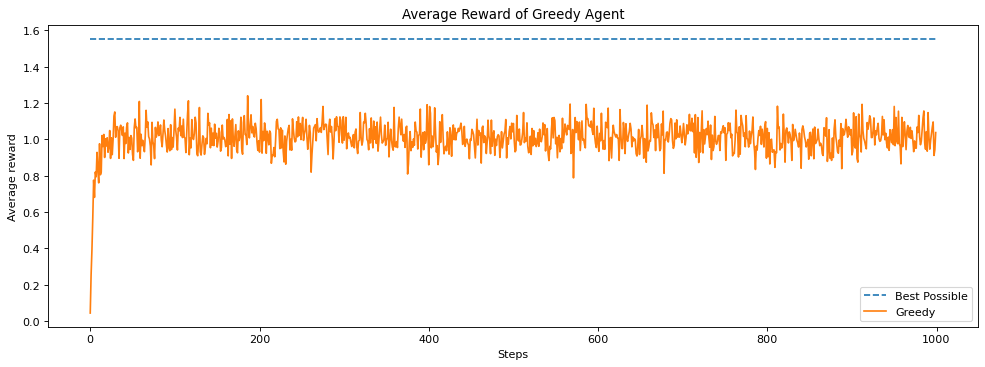

In [9]:
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

rewards = np.zeros((num_runs, num_steps))
average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        rewards[run, i] = reward

greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

### Epsilon-Greedy Agent

In [10]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update Q values
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size * (reward - self.q_values[self.last_action])
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.
        if np.random.random(1) < self.epsilon:
            current_action = np.random.choice(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

100%|██████████| 200/200 [00:10<00:00, 18.29it/s]


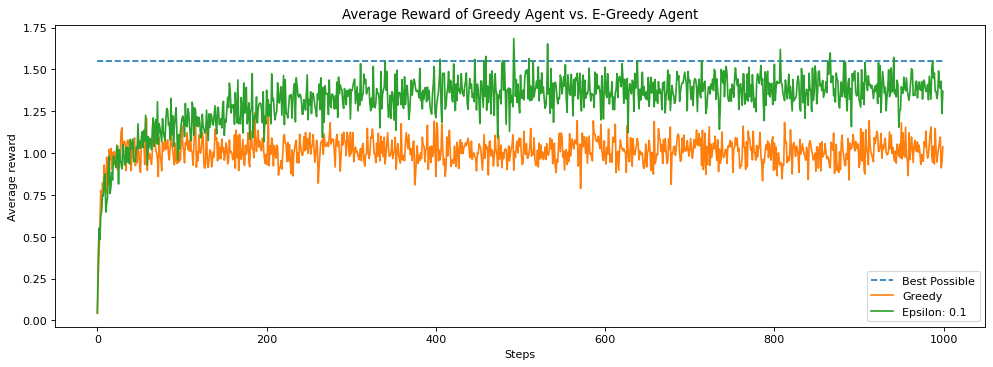

In [11]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_rewards = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        all_rewards[run, i] = reward

# take the mean over runs
scores = np.mean(all_rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(scores)
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()